In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# to output everything in a cell instead of only the last output

# standard imports
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers
import random
from sklearn import preprocessing
from keras.callbacks import History
import matplotlib.pyplot as plt
from keras.utils import np_utils
import os
from tensorflow.keras.optimizers import Adam
from plain_neural_network import*
from keras import backend as K

%matplotlib inline

2022-04-17 21:09:36.443429: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /global/AWIsoft/proj/4.9.3/lib:/global/AWIsoft/intel//2018/intelpython2/lib
2022-04-17 21:09:36.443460: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
input_dir = "/work/ollie/bpanthi/nn_interpolation_new/"
input_file_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
    ])
input_file_paths.pop(29)
input_file_paths.pop(11)

data_x = xr.open_mfdataset(input_file_paths,combine = 'nested', concat_dim="TIME")
data_x = data_x.ssh.to_numpy()
X = np.float32(data_x)
                            
X[X>1000] = 0
print(X.shape)

'/work/ollie/bpanthi/nn_interpolation_new/ssh_gridded_1963_001_06_new.nc'

'/work/ollie/bpanthi/nn_interpolation_new/ssh_gridded_1961_001_12_new.nc'

(1034, 1200, 480)


In [3]:
input_dir = "/home/ollie/ssunar/segmentation_masks_3_years"
input_file_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
    ])
input_file_paths.pop(29)
input_file_paths.pop(11)

data_y = xr.open_mfdataset(input_file_paths,combine = 'nested', concat_dim="TIME")
data_y = data_y.seg_mask.to_numpy()
Y = np.float32(data_y)
print(Y.shape)

'/home/ollie/ssunar/segmentation_masks_3_years/segmentation_mask_nn_1963_001_06_new.nc'

'/home/ollie/ssunar/segmentation_masks_3_years/segmentation_mask_nn_1961_001_12_new.nc'

(1034, 1200, 480)


In [4]:
temp_x_1 = X[:,0:256, 0:256]
temp_x_2 = X[:,0:256, 224:480]
temp_y_1 = Y[:,0:256, 0:256]
temp_y_2 = Y[:,0:256, 224:480]
data_x = np.concatenate((temp_x_1,temp_x_2), axis=0)
data_y = np.concatenate((temp_y_1,temp_y_2), axis=0)

for i in range(1,4):
    temp_x_1 = X[:,256*i:256*(i+1), 0:256]
    temp_x_2 = X[:,256*i:256*(i+1), 224:480]
    temp_y_1 = Y[:,256*i:256*(i+1), 0:256]
    temp_y_2 = Y[:,256*i:256*(i+1), 224:480]
    data_x = np.concatenate((data_x, np.concatenate((temp_x_1,temp_x_2), axis=0)), axis=0)
    data_y = np.concatenate((data_y, np.concatenate((temp_y_1,temp_y_2), axis=0)), axis=0)
    
print("Shape of data X:", data_x.shape)  
print("Shape of data Y:",data_y.shape)

Shape of data X: (8272, 256, 256)
Shape of data Y: (8272, 256, 256)


In [5]:
img_size = (256, 256)
num_classes = 3
batch_size = 16
epochs = 60
total_samples = len(data_x)
print(total_samples)

8272


In [6]:
model = get_model(img_size, num_classes)
model.summary()

2022-04-17 21:10:41.313500: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /global/AWIsoft/proj/4.9.3/lib:/global/AWIsoft/intel//2018/intelpython2/lib
2022-04-17 21:10:41.313526: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-17 21:10:41.313544: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (prod-0121): /proc/driver/nvidia/version does not exist
2022-04-17 21:10:41.313768: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 separable_conv2d (SeparableCon  (None, 256, 256, 16  25         ['input_1[0][0]']                
 v2D)                           )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['separable_conv2d[0][0]']       
 alization)                     )                                                             

                                                                                                  
 batch_normalization_7 (BatchNo  (None, 32, 32, 32)  128         ['separable_conv2d_7[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 activation_7 (Activation)      (None, 32, 32, 32)   0           ['batch_normalization_7[0][0]']  
                                                                                                  
 dropout_3 (Dropout)            (None, 32, 32, 32)   0           ['activation_7[0][0]']           
                                                                                                  
 up_sampling2d (UpSampling2D)   (None, 64, 64, 32)   0           ['dropout_3[0][0]']              
                                                                                                  
 concatena

                                )                                                                 
                                                                                                  
 separable_conv2d_14 (Separable  (None, 256, 256, 3)  64         ['dropout_6[0][0]']              
 Conv2D)                                                                                          
                                                                                                  
 reshape (Reshape)              (None, 65536, 3)     0           ['separable_conv2d_14[0][0]']    
                                                                                                  
 activation_14 (Activation)     (None, 65536, 3)     0           ['reshape[0][0]']                
                                                                                                  
Total params: 13,897
Trainable params: 13,257
Non-trainable params: 640
_____________________________________

In [7]:
#Loss function 
#defined from the paper:
#Santana et al._2020_Neural network training for the detection and classification of oceanic mesoscale eddies

unique, counts = np.unique(data_y, return_counts=True)
dict(zip(unique, counts))

freq = [np.sum(counts)/j for j in counts]
weightsSeg = [f/np.sum(freq) for f in freq]

def dice_coef_anti(y_true, y_pred):
    smooth = 1.  # to avoid zero division
    y_true_anti = y_true[:,:,1]
    y_pred_anti = y_pred[:,:,1]
    intersection_anti = K.sum(y_true_anti * y_pred_anti)
    return (2 * intersection_anti + smooth) / (K.sum(y_true_anti)+ K.sum(y_pred_anti) + smooth)

def dice_coef_cyc(y_true, y_pred):
    smooth = 1.  # to avoid zero division
    y_true_cyc = y_true[:,:,2]
    y_pred_cyc = y_pred[:,:,2]
    intersection_cyc = K.sum(y_true_cyc * y_pred_cyc)
    return (2 * intersection_cyc + smooth) / (K.sum(y_true_cyc) + K.sum(y_pred_cyc) + smooth)

def dice_coef_nn(y_true, y_pred):
    smooth = 1.  # to avoid zero division
    y_true_nn = y_true[:,:,0]
    y_pred_nn = y_pred[:,:,0]
    intersection_nn = K.sum(y_true_nn * y_pred_nn)
    return (2 * intersection_nn + smooth) / (K.sum(y_true_nn) + K.sum(y_pred_nn) + smooth)
    
def mean_dice_coef(y_true, y_pred):
    return (dice_coef_anti(y_true, y_pred) + dice_coef_cyc(y_true, y_pred) + dice_coef_nn(y_true, y_pred))/3.

def weighted_mean_dice_coef(y_true, y_pred):
    return (weightsSeg[2]*dice_coef_anti(y_true, y_pred) + weightsSeg[1]*dice_coef_cyc(y_true, y_pred) + weightsSeg[0]*dice_coef_nn(y_true, y_pred))
  
def dice_coef_loss(y_true, y_pred):
    return 1 - weighted_mean_dice_coef(y_true, y_pred)

{0.0: 493825859, 1.0: 24870368, 2.0: 23417565}

In [8]:
# Split our img paths into a training and a validation set
split = 0.2
train_samples = int((1-split)*total_samples)
#same seed must be used
random.Random(0).shuffle(data_x)
random.Random(0).shuffle(data_y)
train_input = data_x[0:train_samples]
train_target = data_y[0:train_samples]
val_input = data_x[train_samples:total_samples]
val_target = data_y[train_samples:total_samples]

print("train_input:", train_input.shape)
print("val_input:", val_input.shape)

# Instantiate data Sequences for each split
train_gen = plain_net_eddy(batch_size, img_size, train_input, train_target)
val_gen = plain_net_eddy(batch_size, img_size, val_input, val_target)
print("Size of each batch: ",train_gen[1][0].shape)

train_input: (6617, 256, 256)
val_input: (1655, 256, 256)
Size of each batch:  (16, 256, 256, 1)


In [9]:
file_path_save = "/work/ollie/bpanthi/NN_weights"
model.compile(optimizer=Adam(lr=1e-3), loss=dice_coef_loss, metrics=['categorical_accuracy', mean_dice_coef, weighted_mean_dice_coef])

callbacks = [keras.callbacks.ModelCheckpoint(file_path_save, save_best_only=True , monitor='val_loss',save_weights_only=True),
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, mode='auto', min_delta=1e-30, min_lr=1e-30)]

# Train the model, doing validation at the end of each epoch.
history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks, shuffle=True,verbose=1)

Epoch 1/60


/home/ollie/bpanthi/.conda/envs/eddy-tracking/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


413/413 [==============================] - 294s 707ms/step - loss: 0.7472 - categorical_accuracy: 0.6914 - mean_dice_coef: 0.4106 - weighted_mean_dice_coef: 0.2528 - val_loss: 0.9768 - val_categorical_accuracy: 0.9143 - val_mean_dice_coef: 0.3186 - val_weighted_mean_dice_coef: 0.0232 - lr: 0.0010
Epoch 2/60
413/413 [==============================] - 291s 706ms/step - loss: 0.5497 - categorical_accuracy: 0.9041 - mean_dice_coef: 0.6074 - weighted_mean_dice_coef: 0.4503 - val_loss: 0.7547 - val_categorical_accuracy: 0.9175 - val_mean_dice_coef: 0.4704 - val_weighted_mean_dice_coef: 0.2453 - lr: 0.0010
Epoch 3/60
413/413 [==============================] - 291s 705ms/step - loss: 0.5151 - categorical_accuracy: 0.9128 - mean_dice_coef: 0.6328 - weighted_mean_dice_coef: 0.4849 - val_loss: 0.6098 - val_categorical_accuracy: 0.9111 - val_mean_dice_coef: 0.5680 - val_weighted_mean_dice_coef: 0.3902 - lr: 0.0010
Epoch 4/60
413/413 [==============================] - 291s 704ms/step - loss: 0.4984

413/413 [==============================] - 346s 838ms/step - loss: 0.4242 - categorical_accuracy: 0.9306 - mean_dice_coef: 0.6981 - weighted_mean_dice_coef: 0.5758 - val_loss: 0.5159 - val_categorical_accuracy: 0.9210 - val_mean_dice_coef: 0.6341 - val_weighted_mean_dice_coef: 0.4841 - lr: 0.0010
Epoch 28/60
413/413 [==============================] - 344s 833ms/step - loss: 0.4237 - categorical_accuracy: 0.9305 - mean_dice_coef: 0.6983 - weighted_mean_dice_coef: 0.5763 - val_loss: 0.5170 - val_categorical_accuracy: 0.9211 - val_mean_dice_coef: 0.6327 - val_weighted_mean_dice_coef: 0.4830 - lr: 0.0010
Epoch 29/60
413/413 [==============================] - 345s 835ms/step - loss: 0.4227 - categorical_accuracy: 0.9310 - mean_dice_coef: 0.6991 - weighted_mean_dice_coef: 0.5773 - val_loss: 0.5652 - val_categorical_accuracy: 0.9204 - val_mean_dice_coef: 0.6003 - val_weighted_mean_dice_coef: 0.4348 - lr: 0.0010
Epoch 30/60
413/413 [==============================] - 343s 831ms/step - loss: 0.4

413/413 [==============================] - 346s 839ms/step - loss: 0.4095 - categorical_accuracy: 0.9333 - mean_dice_coef: 0.7086 - weighted_mean_dice_coef: 0.5905 - val_loss: 0.5423 - val_categorical_accuracy: 0.9252 - val_mean_dice_coef: 0.6162 - val_weighted_mean_dice_coef: 0.4577 - lr: 0.0010
Epoch 54/60
413/413 [==============================] - 348s 843ms/step - loss: 0.4092 - categorical_accuracy: 0.9332 - mean_dice_coef: 0.7088 - weighted_mean_dice_coef: 0.5908 - val_loss: 0.5538 - val_categorical_accuracy: 0.9265 - val_mean_dice_coef: 0.6092 - val_weighted_mean_dice_coef: 0.4462 - lr: 0.0010
Epoch 55/60
413/413 [==============================] - 350s 849ms/step - loss: 0.4088 - categorical_accuracy: 0.9336 - mean_dice_coef: 0.7091 - weighted_mean_dice_coef: 0.5912 - val_loss: 0.5449 - val_categorical_accuracy: 0.9261 - val_mean_dice_coef: 0.6148 - val_weighted_mean_dice_coef: 0.4551 - lr: 0.0010
Epoch 56/60
413/413 [==============================] - 348s 843ms/step - loss: 0.4

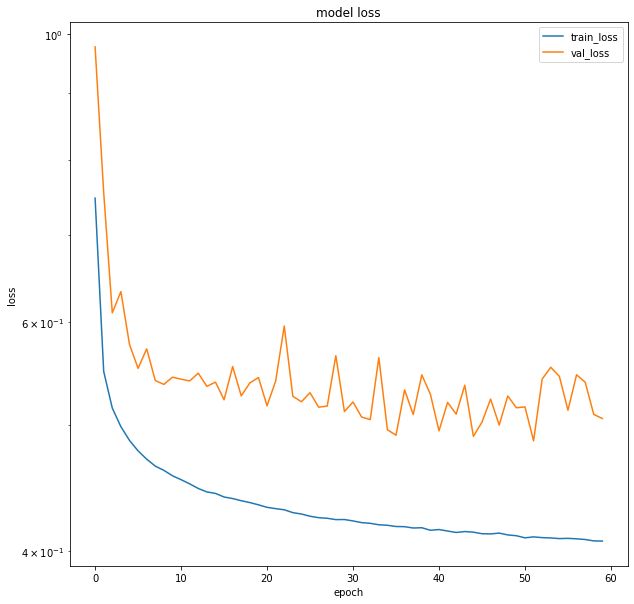

In [10]:
plt.figure(figsize=(10, 10))
plt.semilogy(model.history.history['loss'])
plt.semilogy(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper right');

In [11]:
import time
start = time.time()

val_gen = plain_net_eddy(batch_size, img_size, val_input, val_target)
val_preds = model.predict(val_gen)
print(val_preds.shape)

end = time.time()
time_per_img = (end - start)/1655
print("Time Per image:",time_per_img)
print("Time for 1 year eqv:",time_per_img*365)

(1648, 65536, 3)
Time Per image: 0.009297498835537729
Time for 1 year eqv: 3.393587074971271


In [12]:
# val_gen = plain_net_eddy(batch_size, img_size, val_input, val_target)
# mask = np.expand_dims(val_preds, axis=-1)
val_gen = data_x[180]
val_gen = np.reshape(val_gen,(1,img_size[0],img_size[1],1))
print(val_gen.shape)
val_preds = model.predict(val_gen)
print(val_preds.shape)

(1, 256, 256, 1)
(1, 65536, 3)


<Figure size 1440x720 with 0 Axes>

<AxesSubplot:>

(-0.5, 255.5, 255.5, -0.5)

Text(0.5, 1.0, 'Result Segmentation')

<AxesSubplot:>

(-0.5, 255.5, 255.5, -0.5)

Text(0.5, 1.0, 'Groundtruth Segmentation')

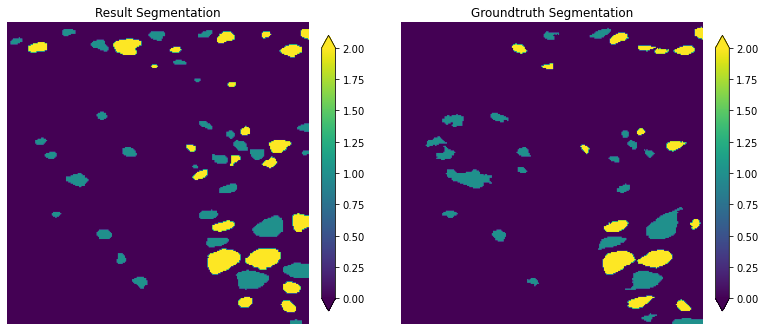

In [13]:
#seeing the prediction of one image of the validation set
%matplotlib inline
mask = np.argmax(np.reshape(val_preds[0],(1,img_size[1],img_size[0],3)), axis=-1)
mask = np.reshape(mask,(img_size[0],img_size[1]))

plt.figure(figsize=(20, 10))

plt.subplot(131)
plt.imshow(mask.T, cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
plt.axis('off')
plt.title('Result Segmentation');
plt.savefig('prediction.png')

plt.subplot(132)
plt.imshow(data_y[180].T, cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
plt.axis('off')
plt.title('Groundtruth Segmentation');
plt.savefig('groundtruth.png')